<a href="https://colab.research.google.com/github/michp15/statistical_learning_class/blob/main/stat_learn_classif_proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install necessary packages.

install.packages('glmnet')
install.packages('caret')
install.packages('car')
install.packages('rsample')
install.packages('MLmetrics')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘iterators’, ‘foreach’, ‘shape’, ‘RcppEigen’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘diagram’, ‘lava’, ‘prodlim’, ‘proxy’, ‘clock’, ‘gower’, ‘hardhat’, ‘ipred’, ‘sparsevctrs’, ‘timeDate’, ‘e1071’, ‘ModelMetrics’, ‘plyr’, ‘pROC’, ‘recipes’, ‘reshape2’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘rbibutils’, ‘cowplot’, ‘Deriv’, ‘microbenchmark’, ‘Rdpack’, ‘doBy’, ‘SparseM’, ‘MatrixModels’, ‘minqa’, ‘nloptr’, ‘reformulas’, ‘carData’, ‘abind’, ‘Formula’, ‘pbkrtest’, ‘quantreg’, ‘lme4’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘warp’, ‘furrr’, ‘slider’


I

In [ ]:
# Import packages.

library(utils)
library(tidyverse)
library(caret)
library(car)
library(rsample)
library(MLmetrics)
library(MASS)
library(e1071)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode


The following object is masked from ‘package:purrr’:

    some



Attaching package: ‘MLmetrics’


The following objects are masked from ‘package:caret’:

    MAE, RMSE


The following object is masked from ‘package:

In [ ]:
# Download dataset.

download.file('https://raw.githubusercontent.com/michp15/statistical_learning_class/refs/heads/main/bank-additional-full.csv', 'bank.csv')

In [ ]:
# Read dataset.

df = read.csv('bank.csv', sep=';')

In [ ]:
# Inspect dataset for correct formatting.

head(df)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,⋯,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<int>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,⋯,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no
2,57,services,married,high.school,unknown,no,no,telephone,may,mon,⋯,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no
3,37,services,married,high.school,no,yes,no,telephone,may,mon,⋯,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no
4,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,⋯,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no
5,56,services,married,high.school,no,no,yes,telephone,may,mon,⋯,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no
6,45,services,married,basic.9y,unknown,no,no,telephone,may,mon,⋯,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no


In [ ]:
# View types.

str(df)

'data.frame':	41188 obs. of  21 variables:
 $ age           : int  56 57 37 40 56 45 59 41 24 25 ...
 $ job           : chr  "housemaid" "services" "services" "admin." ...
 $ marital       : chr  "married" "married" "married" "married" ...
 $ education     : chr  "basic.4y" "high.school" "high.school" "basic.6y" ...
 $ default       : chr  "no" "unknown" "no" "no" ...
 $ housing       : chr  "no" "no" "yes" "no" ...
 $ loan          : chr  "no" "no" "no" "no" ...
 $ contact       : chr  "telephone" "telephone" "telephone" "telephone" ...
 $ month         : chr  "may" "may" "may" "may" ...
 $ day_of_week   : chr  "mon" "mon" "mon" "mon" ...
 $ duration      : int  261 149 226 151 307 198 139 217 380 50 ...
 $ campaign      : int  1 1 1 1 1 1 1 1 1 1 ...
 $ pdays         : int  999 999 999 999 999 999 999 999 999 999 ...
 $ previous      : int  0 0 0 0 0 0 0 0 0 0 ...
 $ poutcome      : chr  "nonexistent" "nonexistent" "nonexistent" "nonexistent" ...
 $ emp.var.rate  : num  1.1 1.1 1.1 1

In [ ]:
# View distributions of categorical data.

for (col in colnames(df)){
  if (!is.numeric(df[, col])){
    print(col)
    print(table(df[, col]))
    cat('\n\n')
  }
}

[1] "job"

       admin.   blue-collar  entrepreneur     housemaid    management 
        10422          9254          1456          1060          2924 
      retired self-employed      services       student    technician 
         1720          1421          3969           875          6743 
   unemployed       unknown 
         1014           330 


[1] "marital"

divorced  married   single  unknown 
    4612    24928    11568       80 


[1] "education"

           basic.4y            basic.6y            basic.9y         high.school 
               4176                2292                6045                9515 
         illiterate professional.course   university.degree             unknown 
                 18                5243               12168                1731 


[1] "default"

     no unknown     yes 
  32588    8597       3 


[1] "housing"

     no unknown     yes 
  18622     990   21576 


[1] "loan"

     no unknown     yes 
  33950     990    6248 


[1] "contact"

In [ ]:
# Remove the 'duration' column. Removing 'duration' prevents data leakage.

duration_vec <- c()
index <- 1
for (col in colnames(df)){
  if (col == 'duration'){
    duration_vec[index] <- TRUE
  } else {
    duration_vec[index] <- FALSE
  }
  index <- index + 1
}
df <- df[, !duration_vec]
rm(duration_vec)
rm(index)

In [ ]:
# Function that checks for and removes duplicates.

check_remove_duplicates <- function(df) {
  duplicates <- duplicated(df)

  if (any(duplicates)){
    cat('There are:', sum(duplicates), 'duplicates.')
    df <- df[!duplicates,]
    cat('\n\nDuplicates removed.')
  }

  return (df)
}

In [ ]:
# Remove duplicates.

df <- check_remove_duplicates(df)

There are: 1784 duplicates.

Duplicates removed.

In [ ]:
# Check for null values.

cat(any(is.na(df)))

FALSE

In [ ]:
# Check dependent variable distribution.

table(df$y)


   no   yes 
34806  4598 

In [ ]:
# Check the proportion of the value 'unknown' per column

for (i in 1:ncol(df)){
  if (is.character(df[, i])){
    print(i)
    print((sum(df[, i] == 'unknown') / nrow(df)))
  }
}

[1] 2
[1] 0.008247894
[1] 3
[1] 0.002004873
[1] 4
[1] 0.04278753
[1] 5
[1] 0.2097757
[1] 6
[1] 0.02487057
[1] 7
[1] 0.02487057
[1] 8
[1] 0
[1] 9
[1] 0
[1] 10
[1] 0
[1] 14
[1] 0
[1] 20
[1] 0


In [ ]:
colnames(df)[5]

[1] "default"

In [ ]:
df <- subset(df, select = -default)

In [ ]:
df <- df[!apply(df, 1, function(row) any(row == 'unknown')), ]

In [ ]:
dim(df)

[1] 36518    19

In [ ]:
# The number of rows that have 'pdays' equal to 999.

sum(df$pdays == 999)

[1] 35153

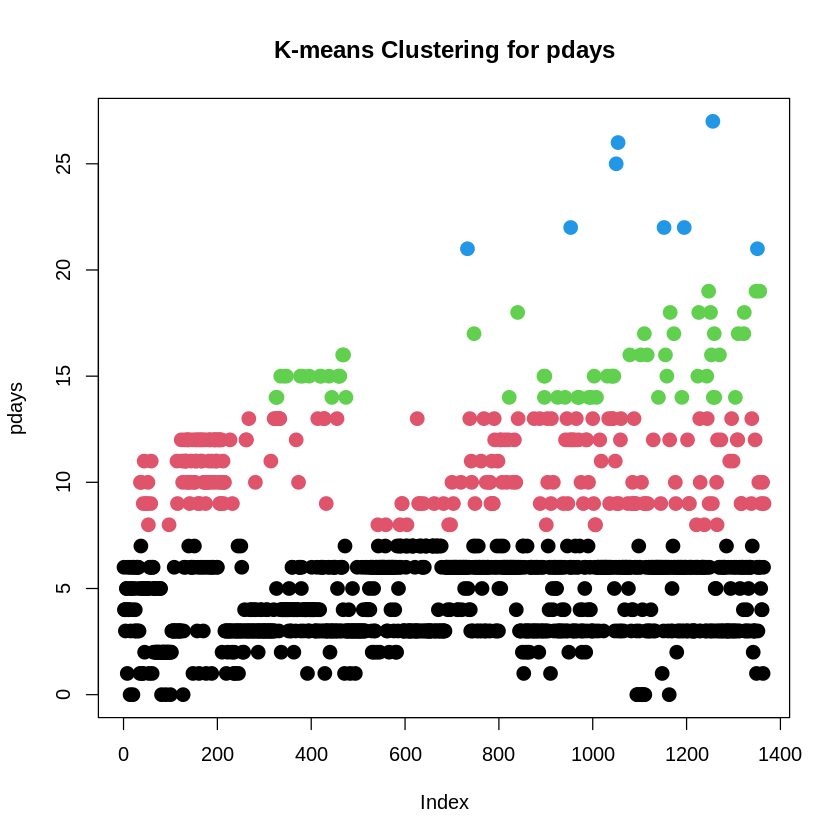

In [ ]:
# Cluster 'pdays' in meaningful categories to resolve the '999' problem

set.seed(123)
kmeans_result <- kmeans(df[df$pdays != 999, 'pdays'], centers = 4, algorithm='Hartigan-Wong')
plot(df[df$pdays != 999, 'pdays'],
     col = kmeans_result$cluster,
     pch = 19,
     main = "K-means Clustering for pdays",
     xlab = "Index",
     ylab = "pdays",
     col.axis = "black",
     cex = 1.5)

In [ ]:
# Check cluster separation.

kmeans_result$betweenss / kmeans_result$totss # -> well separated clusters

[1] 0.8102364

In [ ]:
# The cluster centroids.

kmeans_result$centers

1,4.30000
2,10.65778
3,15.46774
4,23.25000


In [ ]:
# Function to get the index of the minimum value in a vector.

argmin <- function(vec){
  min <- vec[1]
  min_index <- 1
  for (i in 1:length(vec)){
    if (vec[i] < min){
      min <- vec[i]
      min_index <- i
    }
  }
  return (min_index)
}

# Function to compute the Euclidean distance between two 1D points.

euc_distance <- function(x, y){
  return (abs(y - x))  # sqrt((y - x)^2) simplifies to abs(y - x)
}

# Function to find the index of the closest value in a 1D vector.

argmin_distances <- function(x, vec){
  distances <- sapply(vec, function(v) euc_distance(x, v))
  return (argmin(distances))
}

# Encoding 'pdays' based on proximity to k-means cluster centers.

pdays_new_values <- character(nrow(df))

for (i in 1:nrow(df)){
  if (df[i, 'pdays'] == 999){
    pdays_new_values[i] <- 'never'
  } else {
    temp <- argmin_distances(df[i, 'pdays'], kmeans_result$centers)
    temp <- switch(temp,
                   '1' = 'very recent',
                   '2' = 'recent',
                   '3' = 'moderate',
                   '4' = 'older')
    pdays_new_values[i] <- temp
  }
}

df$pdays <- pdays_new_values

rm(pdays_new_values)

In [ ]:
# Remove duplicates.

df <- check_remove_duplicates(df)

There are: 215 duplicates.

Duplicates removed.

In [ ]:
# Find unique values for each categorical column.

for (colname in colnames(df)){
  if (!is.numeric(df[[colname]])){
    cat(colname,'\n')
    cat(unique(df[[colname]]))
    cat('\n\n')
  }
}

job 
housemaid services admin. technician blue-collar retired management unemployed self-employed entrepreneur student

marital 
married single divorced

education 
basic.4y high.school basic.6y basic.9y professional.course university.degree illiterate

housing 
no yes

loan 
no yes

contact 
telephone cellular

month 
may jun jul aug oct nov dec mar apr sep

day_of_week 
mon tue wed thu fri

pdays 
never very recent recent moderate older

poutcome 
nonexistent failure success

y 
no yes



In [ ]:
# Encode dependent variable 'y'.

df$y <- as.factor(ifelse(df$y == 'yes', 1, 0))

In [ ]:
# Encode 'month' and 'day_of_week' columns.

for (i in 1:nrow(df)){
  df[i, 'month'] <- switch(df[i, 'month'],
                           'mar' = 0,
                           'apr' = 1,
                           'may' = 2,
                           'jun' = 3,
                           'jul' = 4,
                           'aug' = 5,
                           'sep' = 6,
                           'oct' = 7,
                           'nov' = 8,
                           'dec' = 9)

  df[i, 'day_of_week'] <- switch(df[i, 'day_of_week'],
                                 'mon' = 0,
                                 'tue' = 1,
                                 'wed' = 2,
                                 'thu' = 3,
                                 'fri' = 4)
}

df$month <- as.numeric(df$month)
df$day_of_week <- as.numeric(df$day_of_week)

df$sin_month <- sin(2 * pi * df$month / 10)
df$cos_month <- cos(2 * pi * df$month / 10)
df$sin_day_of_week <- sin(2 * pi * df$day_of_week / 5)
df$cos_day_of_week <- cos(2 * pi * df$day_of_week / 5)

df <- subset(df, select = -c(month, day_of_week))

In [ ]:
# Encode the 'contact' column.

names(df)[names(df) == 'contact'] <- 'mobile_phone'
df$mobile_phone <- as.integer(ifelse(df$mobile_phone == 'cellular', 1, 0))

In [ ]:
# Encode 'housing' and 'loan'

df$housing <- as.integer(ifelse(df$housing == 'yes', 1, 0))
df$loan <- as.integer(ifelse(df$loan == 'yes', 1, 0))

In [ ]:
# Education to ordered factor

df$education <- factor(df$education,
                       levels = c('illiterate', 'basic.4y', 'high.school', 'basic.6y', 'basic.9y', 'professional.course', 'university.degree'),
                       ordered = TRUE)

In [ ]:
# Pdays to ordered factor

df$pdays <- factor(df$pdays,
                   levels = c('never', 'very recent', 'recent', 'moderate', 'older'),
                   ordered = TRUE)

In [ ]:
# Remove duplicates.

df <- check_remove_duplicates(df)

In [ ]:
# Convert all character columns to factors.

df[] <- lapply(df, function(x) if(is.character(x)) as.factor(x) else x)

In [ ]:
write.csv(df, 'bank.csv', row.names = FALSE)

In [ ]:
# Split train val test

split_1 <- initial_split(df, prop = 0.8, strata = 'y')
train <- training(split_1)
temp <- testing(split_1)

split_2 <- initial_split(temp, prop = 0.5, strata = 'y')
val <- training(split_2)
test <- testing(split_2)

In [ ]:
# Calculate y variable class proportions for model weights

class_proportions <- prop.table(table(train$y))
weights <- ifelse(train$y == 1, 1 / class_proportions['1'], 1 / class_proportions['0'])

In [ ]:
table(train$y)


    0     1 
25672  3370 

In [ ]:
# Fit Logistic Regression model

model <- glm(y ~ ., data=train, family=binomial, weights=weights)
summary(model)

Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”



Call:
glm(formula = y ~ ., family = binomial, data = train, weights = weights)

Coefficients:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)         -1.117e+02  9.160e+00 -12.190  < 2e-16 ***
age                 -8.524e-04  1.167e-03  -0.730 0.465175    
jobblue-collar      -9.100e-02  3.629e-02  -2.507 0.012166 *  
jobentrepreneur     -1.545e-01  5.712e-02  -2.705 0.006833 ** 
jobhousemaid        -1.071e-01  6.850e-02  -1.564 0.117918    
jobmanagement       -3.858e-02  4.049e-02  -0.953 0.340678    
jobretired           3.532e-01  5.638e-02   6.265 3.72e-10 ***
jobself-employed    -1.847e-01  5.514e-02  -3.349 0.000810 ***
jobservices         -1.025e-01  3.917e-02  -2.618 0.008856 ** 
jobstudent           3.767e-01  6.867e-02   5.486 4.12e-08 ***
jobtechnician        2.131e-02  3.377e-02   0.631 0.527911    
jobunemployed       -1.195e-01  6.327e-02  -1.889 0.058861 .  
maritalmarried      -7.447e-04  3.170e-02  -0.023 0.981260    
maritalsingle        8.

In [ ]:
# Get VIF values

print(car::vif(model))

                      GVIF Df GVIF^(1/(2*Df))
age               1.773931  1        1.331890
job               4.632493 10        1.079669
marital           1.336721  2        1.075252
education         3.260100  6        1.103492
housing           1.015903  1        1.007920
loan              1.006284  1        1.003137
mobile_phone      2.605386  1        1.614121
campaign          1.047221  1        1.023338
pdays            12.832633  4        1.375750
previous          6.425411  1        2.534840
poutcome         48.136761  2        2.634021
emp.var.rate     39.693180  1        6.300252
cons.price.idx   12.280859  1        3.504406
cons.conf.idx     4.059576  1        2.014839
euribor3m       107.456670  1       10.366131
nr.employed      53.566029  1        7.318882
sin_month         2.310255  1        1.519952
cos_month         2.167689  1        1.472307
sin_day_of_week   1.013990  1        1.006971
cos_day_of_week   1.008220  1        1.004102


In [ ]:
num_vars <- train %>% select(where(is.numeric))
corrplot(cor(num_vars), method = 'color')

ERROR: Error in select(., where(is.numeric)): unused argument (where(is.numeric))


In [ ]:
probabilities <- predict(model, newdata=test, type='response')
predicted_classes <- ifelse(probabilities >= 0.5, 1, 0)

In [ ]:
Precision(test$y, predicted_classes, positive = '1')
Recall(test$y, predicted_classes, positive = '1')
F1_Score(test$y, predicted_classes, positive = '1')
ConfusionMatrix(test$y, predicted_classes)

[1] 0.2984234

[1] 0.6279621

[1] 0.4045802

      y_pred
y_true    0    1
     0 2586  157
     1  623  265

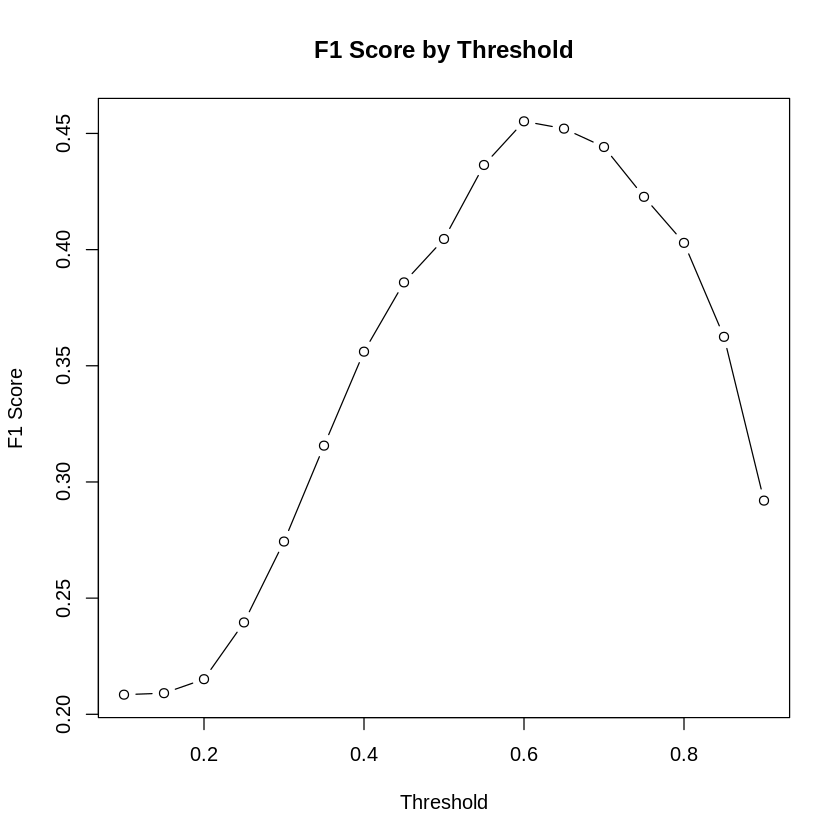

In [ ]:
# Tune for F1 Score

thresholds <- seq(0.1, 0.9, by = 0.05)
f1_scores <- sapply(thresholds, function(t) {
  preds <- ifelse(probabilities >= t, 1, 0)
  f1 <- F1_Score(test$y, preds, positive = '1')
  return(f1)
})

plot(thresholds, f1_scores, type = 'b', main = 'F1 Score by Threshold', ylab = 'F1 Score', xlab = 'Threshold')
best_thresh <- thresholds[which.max(f1_scores)]

In [ ]:
probabilities <- predict(model, newdata=test, type='response')
predicted_classes <- ifelse(probabilities >= 0.6, 1, 0)

In [ ]:
Precision(test$y, predicted_classes, positive = '1')
Recall(test$y, predicted_classes, positive = '1')
F1_Score(test$y, predicted_classes, positive = '1')
ConfusionMatrix(test$y, predicted_classes)

[1] 0.4098672

[1] 0.5118483

[1] 0.455216

      y_pred
y_true    0    1
     0 2898  206
     1  311  216

[1] 0.4027047

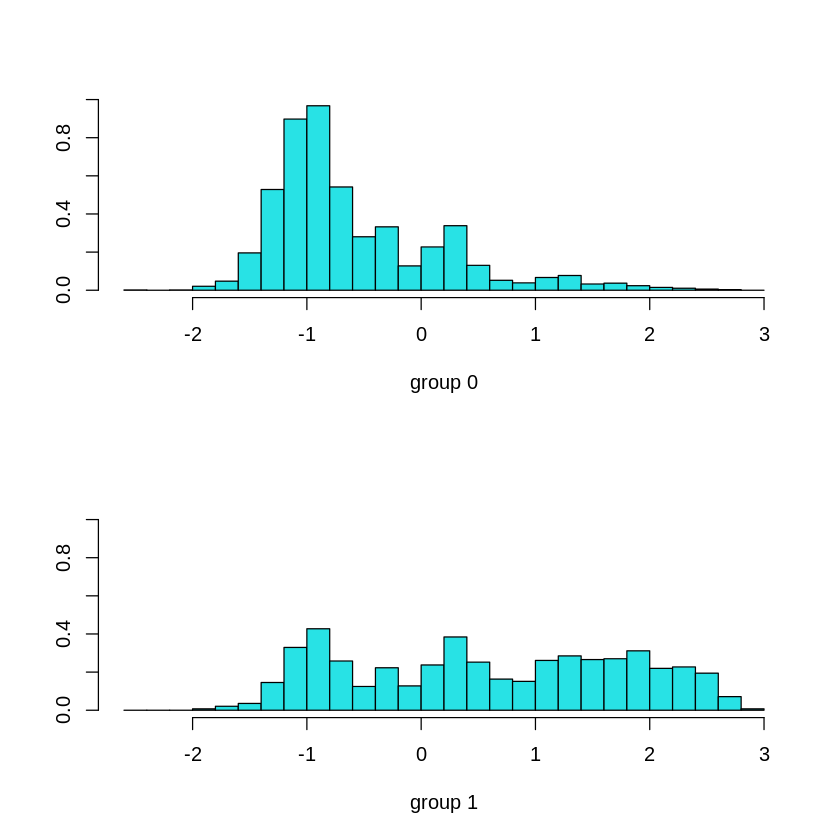

In [ ]:
lda_model <- lda(y ~ ., data = train)
plot(lda_model)
lda_predictions_test <- predict(lda_model, newdata = test)
predicted_classes_test <- lda_predictions_test$class
F1_Score(predicted_classes_test, test$y, positive='1')

In [ ]:
qda_model <- qda(y ~ ., data = train)
summary(qda_model)
qda_predictions_test <- predict(qda_model, newdata = test)
predicted_classes_test <- qda_predictions_test$class
F1_Score(predicted_classes_test, test$y, positive='1')

ERROR: Error in qda.default(x, grouping, ...): rank deficiency in group 0


In [ ]:
nb_model <- naiveBayes(y ~ ., data = train)
nb_preds <- predict(nb_model, newdata = test)
F1_Score(nb_preds, test$y, positive = '1')

[1] 0.3599748